# Naive RAG

Naive RAG is a simplified approach to using LLMs in conjunction with document retrieval for improved information access and response generation. Naive RAG works in three basic steps:

Indexing: Data from formats like PDF or HTML is cleaned up and converted into plain text. This text is then divided into smaller parts (chunks) and turned into vector representations by passing the chunks into the embedding model to make it easier to find later.

Retrieval: When someone asks a question, the RAG system turns that question into vector embedding using the same method used in indexing. Then, it compares this vector to the vectors of the indexed text parts to find the
k
k
 most similar chunks. These
k
k
 most similar chunks are used in the next step as a context.

Generation: The system combines the retrieved text parts (context) with the original question to create a prompt. The language model uses this prompt to answer the question. Depending on the question, the model might use its own knowledge or focus on the information it found earlier.

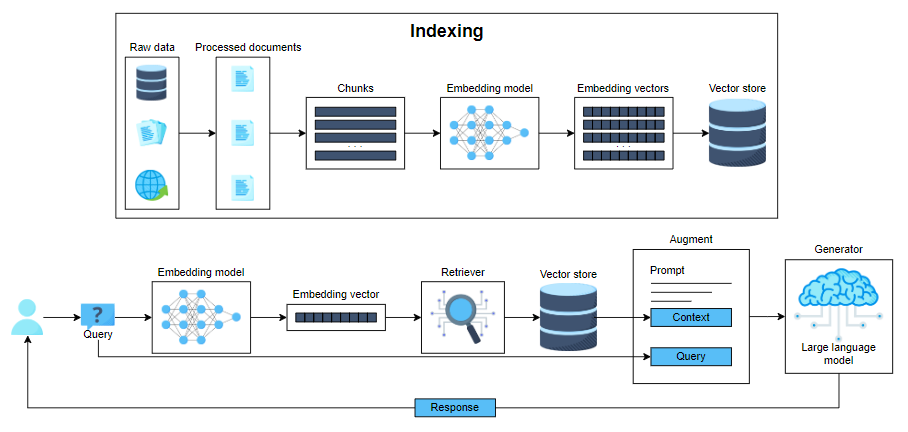

# Import Necessary Libraries



In [2]:
! pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.4
    Uninstalling langchain-0.3.4:
      Successfully uninstalled langchain-0.3.4


In [4]:
! pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.7 MB/s eta 0:00:00


In [8]:
! pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 4.9 MB/s eta 0:00:00


In [12]:
! pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.7/615.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 5.3 MB/s eta 0:00:

# Step 1 : Import Necessary Libraries

Import the necessary libraries and modules. These modules provide functionalities such as handling PDF documents, text splitting, embeddings, vector stores, prompt construction, and interaction with the OpenAI Chat large language model.

In [5]:

import os
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# Step 2 : OpenAI environment variable setup

This section deals with setting up environment variables, particularly the OpenAI API key. This key is necessary for authentication when interacting with the OpenAI API. However, this step is optional, as we can provide the API key directly in the code instead of using an environment variable.

In [6]:

OPENAI_API_KEY = os.environ["OPENAI_API_KEY"] = ""  # Add your OpenAI API Key
if OPENAI_API_KEY is None:
    raise ValueError("Please set the OPENAI_API_KEY environment variable")

# Step 3 : Data Indexing Process

The data indexing process involves loading a PDF document, splitting it into smaller text chunks, creating embeddings for these chunks using an OpenAI model, and storing these embeddings in a vector store.

In [ ]:
DOC_PATH = "C:/Users/ariji/Downloads/Anomaly_Detection_and_Prediction.pdf"
loader = PyPDFLoader(DOC_PATH)
pages = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = text_splitter.split_documents(pages)

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

CHROMA_PATH = "C:/Users/ariji/Exploratory Data Analysis/db"
db_chroma = Chroma.from_documents(chunks, embeddings, persist_directory=CHROMA_PATH)

In [13]:
DOC_PATH = "Attention_is_all_you_need.pdf"
loader = PyPDFLoader(DOC_PATH)
pages = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = text_splitter.split_documents(pages)

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

CHROMA_PATH = "C:/Users/ariji/Exploratory Data Analysis/db"
db_chroma = Chroma.from_documents(chunks, embeddings, persist_directory=CHROMA_PATH)

In [18]:
len(pages)

15

In [21]:
pages[0].page_content

'Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurren

In [22]:
pages[14].page_content

'Input-Input Layer5\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pad>\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pad>\nInput-Input Layer5\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pad>\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pad>\nFigure 5: Many of the attention heads exhibit behaviour that seems related to the structure of the\nsentence. We give two such examples above, from two different heads from the encoder self-attention\nat layer 5 of 6. The heads clearly learned to perform different tasks.\n15'

In [17]:
len(chunks)

93

In [24]:
chunks[0].page_content

'Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu'

In [25]:
chunks[1].page_content

'University of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer,'

In [26]:
query = 'What is a Decoder ?'
docs_chroma = db_chroma.similarity_search_with_score(query, k=5)
context_text = "\n\n".join([doc.page_content for doc, _score in docs_chroma])

In [27]:
print(context_text)

Decoder: The decoder is also composed of a stack of N = 6identical layers. In addition to the two
sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head
attention over the output of the encoder stack. Similar to the encoder, we employ residual connections
around each of the sub-layers, followed by layer normalization. We also modify the self-attention
sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This

3 Model Architecture
Most competitive neural sequence transduction models have an encoder-decoder structure [5, 2, 35].
Here, the encoder maps an input sequence of symbol representations (x1, ..., xn) to a sequence
of continuous representations z = (z1, ..., zn). Given z, the decoder then generates an output
sequence (y1, ..., ym) of symbols one element at a time. At each step the model is auto-regressive

• In "encoder-decoder attention" layers, the queries come from the previous decoder layer,
and

In [28]:
# Respond in German
PROMPT_TEMPLATE = """
Answer the question based only on the following context:
{context}
Answer the question based on the above context: {question}.
Provide a detailed answer.
Don’t justify your answers.
Don’t give information not mentioned in the CONTEXT INFORMATION.
Do not say "according to the context" or "mentioned in the context" or similar.
Write the response in german
"""

prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
prompt = prompt_template.format(context=context_text, question=query)

In [29]:
# Generation Process

model = ChatOpenAI()
response_text = model.invoke(prompt)
print(response_text.content)

Ein Decoder besteht aus einem Stapel von N = 6 identischen Schichten. Neben den beiden Unterebenen in jeder Encoder-Schicht fügt der Decoder eine dritte Unterebene ein, die eine Mehrkopfaufmerksamkeit über die Ausgabe des Encoder-Stapels durchführt. Ähnlich wie beim Encoder verwenden wir Residualverbindungen um jede der Unterebenen herum, gefolgt von einer Schichtnormalisierung. Wir modifizieren auch die Selbst-Aufmerksamkeits-Unterebene im Decoder-Stapel, um zu verhindern, dass Positionen auf nachfolgende Positionen achten.


In [30]:
# Updated prompt
PROMPT_TEMPLATE = """
Answer the question based only on the following context:
{context}
Answer the question based on the above context: {question}.
Provide a detailed answer.
Don’t justify your answers.
Don’t give information not mentioned in the CONTEXT INFORMATION.
Do not say "according to the context" or "mentioned in the context" or similar.

"""

prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
prompt = prompt_template.format(context=context_text, question=query)

In [31]:
# Generation Process

model = ChatOpenAI()
response_text = model.invoke(prompt)
print(response_text.content)

The decoder is composed of a stack of N = 6 identical layers. In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, the decoder employs residual connections around each of the sub-layers, followed by layer normalization. The self-attention sub-layer in the decoder stack is modified to prevent positions from attending to subsequent positions. The decoder in the Transformer model generates an output sequence of symbols one element at a time based on the continuous representations provided by the encoder.


In [32]:
# Updated prompt to generalize the response
PROMPT_TEMPLATE = """
Answer the question based only on the following context:
{context}
Answer the question based on the above context: {question}.
Provide a detailed answer.
Don’t justify your answers.
Don’t give information not mentioned in the CONTEXT INFORMATION.
Do not say "according to the context" or "mentioned in the context" or similar.
Explain in simple words to a person who doesn't have a background in machine learning
"""

prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
prompt = prompt_template.format(context=context_text, question=query)

In [33]:
# Generation Process

model = ChatOpenAI()
response_text = model.invoke(prompt)
print(response_text.content)

The decoder is a part of a neural network model called the Transformer. It is made up of multiple layers and is responsible for generating an output sequence based on the information it receives from the encoder. The decoder has three sub-layers, including one that performs multi-head attention over the output of the encoder. This helps the decoder to understand and process the input information effectively. The decoder also uses residual connections and layer normalization to improve its performance. Additionally, the self-attention sub-layer in the decoder is modified to prevent positions from attending to subsequent positions, ensuring better accuracy in generating the output sequence.


In [34]:
# Updated prompt to generalize the response - v1
PROMPT_TEMPLATE = """
Answer the question based only on the following context:
{context}
Answer the question based on the above context: {question}.
Provide a detailed answer.
Don’t justify your answers.
Don’t give information not mentioned in the CONTEXT INFORMATION.
Do not say "according to the context" or "mentioned in the context" or similar.
Explain in simple words to a person who doesn't have a background in machine learning , don't use a technical term used spicifically in data science
"""

prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
prompt = prompt_template.format(context=context_text, question=query)

In [35]:
# Generation Process

model = ChatOpenAI()
response_text = model.invoke(prompt)
print(response_text.content)

The decoder is a part of a neural network that takes the encoded information from the encoder and uses it to generate an output sequence. It has multiple layers that help it pay attention to different parts of the input sequence and make decisions on what to output next. The decoder is important in tasks like translation, where it takes the encoded information from the input language and generates the corresponding output language.


In [37]:
query = 'What is positional encoding ?'
docs_chroma = db_chroma.similarity_search_with_score(query, k=5)
context_text = "\n\n".join([doc.page_content for doc, _score in docs_chroma])

In [38]:
print(context_text)

bottoms of the encoder and decoder stacks. The positional encodings have the same dimension dmodel
as the embeddings, so that the two can be summed. There are many choices of positional encodings,
learned and fixed [9].
In this work, we use sine and cosine functions of different frequencies:
P E(pos,2i) = sin(pos/100002i/dmodel )
P E(pos,2i+1) = cos(pos/100002i/dmodel )
where pos is the position and i is the dimension. That is, each dimension of the positional encoding

sinusoidal positional encoding with learned positional embeddings [9], and observe nearly identical
results to the base model.
6.3 English Constituency Parsing
To evaluate if the Transformer can generalize to other tasks we performed experiments on English
constituency parsing. This task presents specific challenges: the output is subject to strong structural
constraints and is significantly longer than the input. Furthermore, RNN sequence-to-sequence

Convolutional O(k · n · d2) O(1) O(logk(n))
Self-Attention (restrict

In [39]:
# Respond in french
PROMPT_TEMPLATE = """
Answer the question based only on the following context:
{context}
Answer the question based on the above context: {question}.
Provide a detailed answer.
Don’t justify your answers.
Don’t give information not mentioned in the CONTEXT INFORMATION.
Do not say "according to the context" or "mentioned in the context" or similar.
Write the response in french
"""

prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
prompt = prompt_template.format(context=context_text, question=query)

In [40]:
# Generation Process

model = ChatOpenAI()
response_text = model.invoke(prompt)
print(response_text.content)

Le codage de position consiste à ajouter des informations sur la position relative ou absolue des jetons dans une séquence. Dans le contexte du Transformer, les codages de position sont des fonctions sinus et cosinus de différentes fréquences qui sont ajoutées aux embeddings d'entrée pour permettre au modèle de prendre en compte l'ordre des éléments dans la séquence. Ces informations de position sont essentielles car le modèle Transformer ne contient ni récurrence ni convolution, et donc a besoin de ces codages pour apprendre les dépendances entre les différentes positions des éléments dans la séquence.


# English translation of the french response above :

Position coding involves adding information about the relative or absolute position of tokens in a sequence. In the context of the Transformer, position encodings are sine and cosine functions of different frequencies that are added to the input embeddings to allow the model to take into account the order of elements in the sequence. This positional information is essential because the Transformer model does not contain recurrence or convolution, and therefore needs these encodings to learn the dependencies between different positions of elements in the sequence.